<a href="https://colab.research.google.com/github/tomasz-soltysiak/Fraud_transaction/blob/oversampling/Fraud_dedection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_curve,confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense
from keras.layers import Dropout
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


After adding libraries, I upload data.

In [4]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0


In [0]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df=df.dropna(axis=0)
df.isnull().sum(axis=0)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

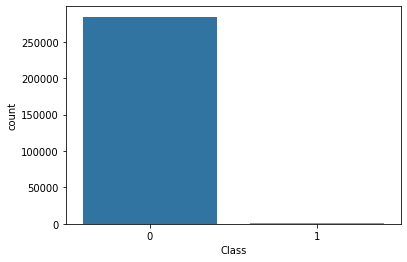

In [0]:
sns.countplot(df['Class'])


In [0]:
pd.Series(df['Class']).value_counts()

0    284315
1       492
Name: Class, dtype: int64

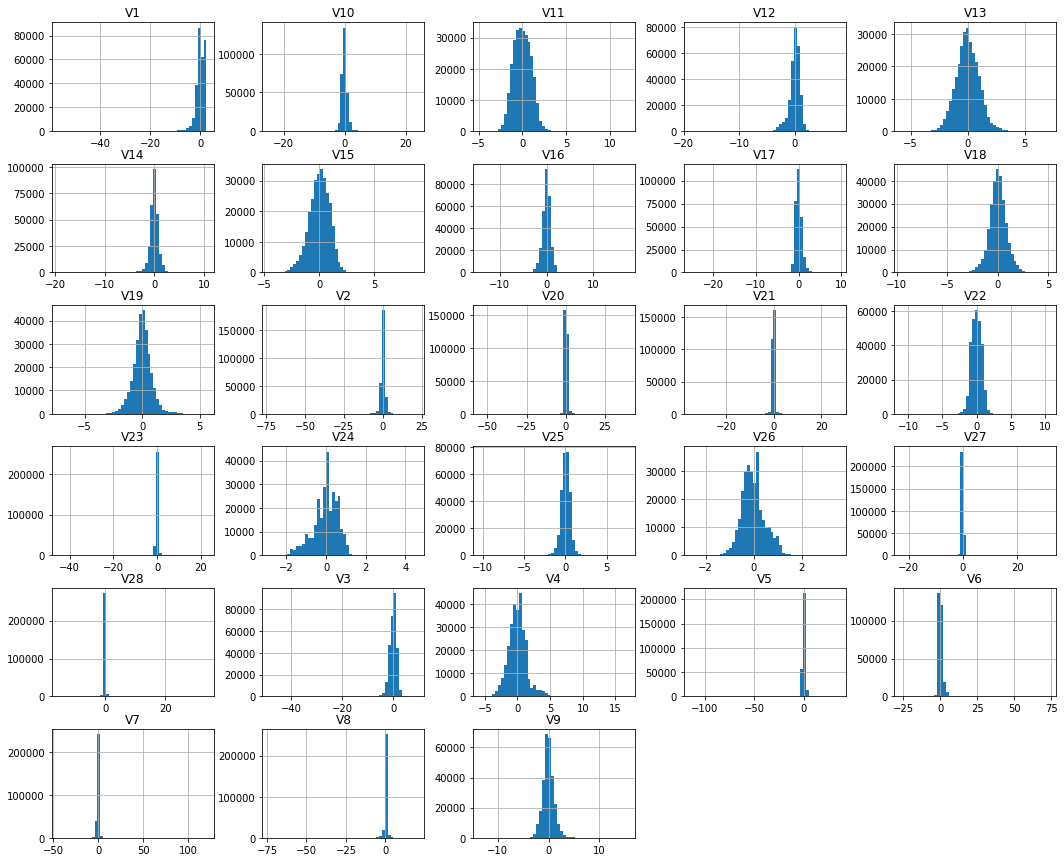

In [0]:
plot = df.drop(["Class", "Amount", "Time"], axis=1).hist(bins=50,
                                                         figsize=(18, 15));

"V1", "V2", "V5", "V6", "V7", "V8", "V10", "V12", "V11", "V14", "V16", "V17", "V15", "V20", "V21", "V23", "V27", "V28" - list of Variables that need to be checked.

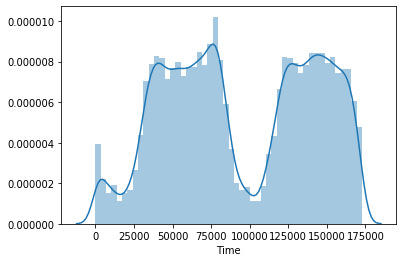

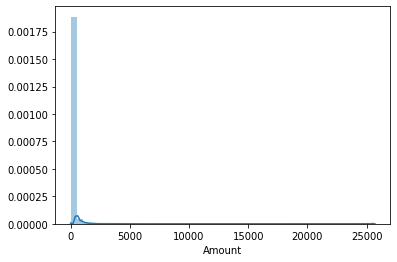

In [0]:
plt.figure()
sns.distplot(df['Time'])
plt.figure()
sns.distplot(df['Amount'])

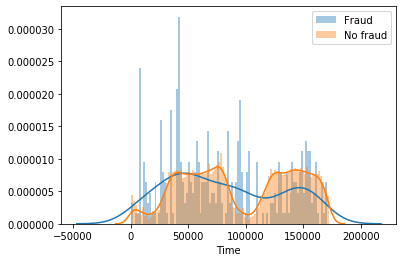

In [6]:
df_fraud=df[df['Class']==1]
df_nofraud=df[df['Class']==0]
sns.distplot(df_fraud['Time'],bins=100)
sns.distplot(df_nofraud['Time'],bins=100)
plt.legend(labels=['Fraud','No fraud'])

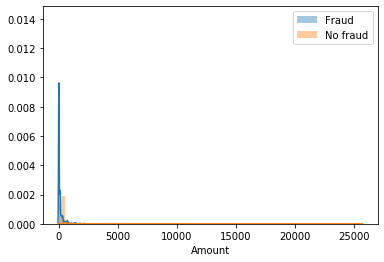

In [0]:
sns.distplot(df_fraud['Amount'])
sns.distplot(df_nofraud['Amount'])
plt.legend(labels=['Fraud','No fraud'])

Przybliżenie wykresu

(-100, 1500)

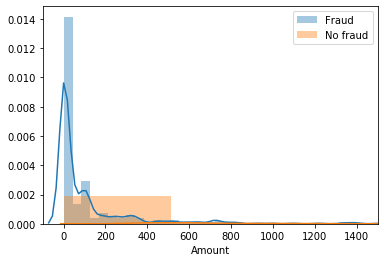

In [0]:
sns.distplot(df_fraud['Amount'])
sns.distplot(df_nofraud['Amount'])
plt.legend(labels=['Fraud','No fraud'])
plt.xlim(-100,1500)

Logarytmowanie kolumny "Amount"

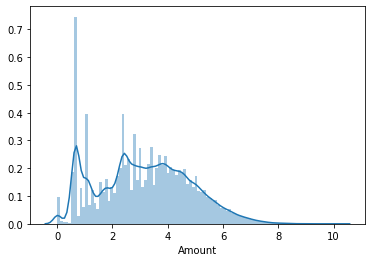

In [0]:
sns.distplot(np.log1p(df["Amount"]), bins=100)

Następnie podział na Fraud/No Fraud

(-1, 8.5)

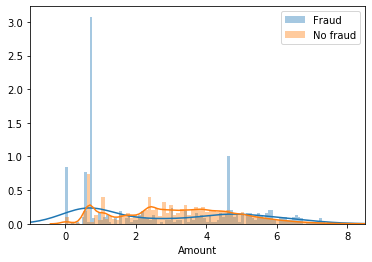

In [0]:
sns.distplot(np.log1p(df[df['Class']==1]["Amount"]), bins=100)
sns.distplot(np.log1p(df[df['Class']==0]["Amount"]), bins=100)
plt.legend(labels=['Fraud','No fraud'])
plt.xlim(-1,8.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'F' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not sup

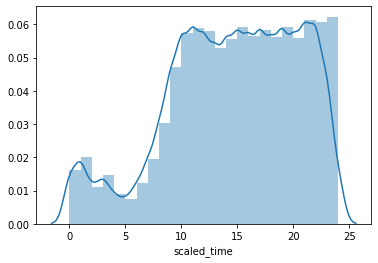

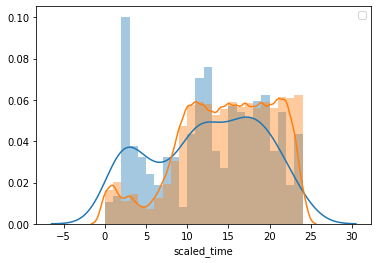

In [7]:
np.floor((172792/3600)%24)
np.floor((89000/3600)%24)

df['scaled_time']=round((df['Time']/3600)%24)
df_fraud=df[df['Class']==1]
df_nofraud=df[df['Class']==0]
df.head()
sns.distplot(df['scaled_time'], bins=24)
plt.figure()
sns.distplot(df_fraud['scaled_time'], bins=24)
sns.distplot(df_nofraud['scaled_time'], bins=24)
plt.legend('Fraud', 'No Fraud')

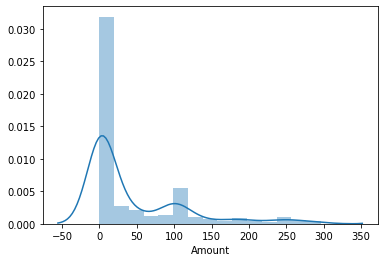

In [0]:

sns.distplot(df_fraud[df_fraud['Amount']<300]['Amount'])

In [0]:
df_fraud.info()
df_fraud.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 541 to 281674
Data columns (total 32 columns):
Time           492 non-null float64
V1             492 non-null float64
V2             492 non-null float64
V3             492 non-null float64
V4             492 non-null float64
V5             492 non-null float64
V6             492 non-null float64
V7             492 non-null float64
V8             492 non-null float64
V9             492 non-null float64
V10            492 non-null float64
V11            492 non-null float64
V12            492 non-null float64
V13            492 non-null float64
V14            492 non-null float64
V15            492 non-null float64
V16            492 non-null float64
V17            492 non-null float64
V18            492 non-null float64
V19            492 non-null float64
V20            492 non-null float64
V21            492 non-null float64
V22            492 non-null float64
V23            492 non-null float64
V24            492 non-nul

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0,492.000000
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0,12.111789
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,2.678605,4.654458,1.104518,4.278940,1.049915,3.865035,6.970618,2.899366,1.539853,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0,6.754474
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-1.702228,-18.683715,-3.127795,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0,0.000000
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,-7.756698,1.973397,-8.688177,-0.979117,-9.692723,-0.643539,-6.562915,-11.945057,-4.664576,-0.299423,-0.171760,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0,6.000000
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.729720,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0,12.000000
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,-2.614184,5.307078,-2.974088,0.672964,-4.282821,0.609189,-1.226043,-1.341940,0.091772,1.649318,0.822445,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0,18.000000
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,12.018913,1.375941,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0,24.000000


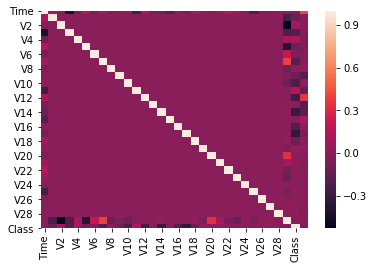

In [0]:
sns.heatmap(df.corr())

In [8]:
Rob_scaler=RobustScaler()

df['scaled_Amount']=Rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time,scaled_Amount
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0,11.0,0.601848
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0,15.0,-0.293994
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0,19.0,0.121798
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0,10.0,1.849223
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0,10.0,-0.167997


In [0]:
df['scaled_Amount'].describe()

count    284807.000000
mean          0.927124
std           3.495006
min          -0.307413
25%          -0.229162
50%           0.000000
75%           0.770838
max         358.683155
Name: scaled_Amount, dtype: float64

Jakub: Jak widać mamy niezbalansowane dane. Jest w sumie 284315 rekordów oznaczonych jako nie fraudy oraz 492 fraudów. Sposobem na poradzenie sobie z tym problemem jest są metody zwane Oversampling oraz Undersampling. Jak w przypadku Undersamplingu nie ma problemu jeśli chodzi o wiarygodność danych, tak w Oversamplingu jest trochę inaczej, ponieważ sztucznie dodajemy na podstawie pewnych funckji. To może spowodować że nasz model w przypadku nowej testowej bazy danych będzie mniej skuteczny. Dlatego nasz projekt będzie uwzględniał trzy metody Undersampling, Oversampling oraz Oversampling z wykorzystaniem SMOTE.

In [0]:
pca_list = list(df.columns.values)
pca_list.remove('Time')
pca_list.remove('Amount')
pca_list.remove('Class')
pca_list.remove('scaled_time')
pca_list.remove('scaled_Amount')

In [0]:
g = sns.pairplot(df, vars = ["V1", "V2", "V5", "V6", "V7", "V8", "V10", "V12", "V11", "V14", "V16", "V17", "V15", "V20", "V21", "V23", "V27", "V28"], hue='Class',
             plot_kws={"alpha": 0.1});


for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50]

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
df_X = df.iloc[:, 0:32]
X_resampled, y_resampled = ros.fit_resample(df_X, df['Class'])


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
X_resampled_cols = list(df.columns.values)
X_resampled_cols.remove('Class')
df_ovsmpl = pd.DataFrame(X_resampled, columns=X_resampled_cols)
df_ovsmpl['Class']=pd.DataFrame(y_resampled)

In [0]:
ov = sns.pairplot(X_resampled ,
                 plot_kws={"alpha": 0.1});


for lh in ov._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50]

Now I am going to use my oversampled data to create some models.

In [12]:
df_ovsmpl=df_ovsmpl.drop(['Time','Amount'],axis=1)
df_ovsmpl.head()

X=df_ovsmpl.drop(columns=['Class'],axis=1)
y=df_ovsmpl['Class']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
df_ovsmpl.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_time,scaled_Amount,Class
0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,0.0,11.0,0
1,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,0.0,15.0,0
2,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,0.0,19.0,0
3,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,0.0,10.0,0
4,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,0.0,10.0,0


In [0]:
def Log_reg(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  log_reg=LogisticRegression()
  penalty=['l1','l2']
  C=np.logspace(0,4,20)
  hyperpara=dict(penalty=penalty,C=C)
  gridsearch=GridSearchCV(log_reg,hyperpara)

  return gridsearch.fit(X_train,y_train)

def Rand_forest(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)


  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  RF=RandomForestClassifier(n_estimators=150)
  

  n_estimators=np.arange(1,20,1)
  criterion=['gini','entropy']
  
  hyperpara=dict(n_estimators=n_estimators,criterion=criterion)
  gridsearch=GridSearchCV(RF,hyperpara)

  return gridsearch.fit(X_train,y_train)

def KNeig(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  Kneig=KNeighborsClassifier(n_neighbors=5)
  n_neighbors=np.arange(1,10,1)
  weights=['uniform','distance']
  #algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']
  hyperpara=dict(n_neighbors=n_neighbors)
  gridsearch=GridSearchCV(Kneig,hyperpara)

  return gridsearch.fit(X_train,y_train)  
  
def XGBoost_(X,y):
  
  
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  xgb=XGBClassifier()
  n_estimators=np.arange(1,20,1)
  silent=[True,False]
  #max_depth=np.arange(1,20,1)  
  hyperpara=dict(n_estimators=n_estimators,silent=silent)
  gridsearch=GridSearchCV(xgb,hyperpara)
  return gridsearch.fit(X_train,y_train) 
def SVC_(X,y):
  
  Sscaler=StandardScaler()
  X=Sscaler.fit_transform(X)
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  svc=SVC(kernel='rbf',random_state=0,gamma=1,C=1)
  C=np.arange(1,5,1)
  kernel=['linear', 'poly']
  hyperpara=dict(C=C,kernel=kernel)
  return GridSearchCV(svc,hyperpara).fit(X_train,y_train)

In [25]:

import os.path
joblib.dump(Log_reg(X,y),'osmpl_Log_Reg.pkl')
joblib.dump(Rand_forest(X,y),'osmpl_Rand_forest.pkl')
joblib.dump(KNeig(X,y),'osmpl_KNeig.pkl')
joblib.dump(XGBoost_(X,y),'osmpl_XGBoost_.pkl')
joblib.dump(SVC_(X,y),'osmpl_SVC_.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

KeyboardInterrupt: ignored

In [21]:
from sklearn.externals import joblib
joblib.dump(XGBoost_(X,y),'osmpl_XGBoost_.pkl')


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


['osmpl_XGBoost_.pkl']

In [0]:
joblib.dump(KNeig(X,y),'osmpl_KNeig.pkl')
#joblib.dump(SVC_(X,y),'osmpl_SVC_.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
